Import of libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold

from collections import defaultdict

import seaborn as sns
import time

Load of dataset. Primary analysis

In [2]:
# Loading a training dataset
df_train = pd.read_csv('datasets/train_kaggle.csv')
df_train.shape

(891, 12)

In [3]:
# Features - 11, Target - Survived, Rows - 891
# You might notice that in dataset there are missing values (Age, Cabin, Embarked)
# We will analyze each feature:
'''
PassengerId - List of people in order (People_train - 891)
Survived - binary target feature (0 - No, 1 - Yes)
Pclass - Ticket class: 1st class (Upper), 2nd class (Middle), 3rd class (Lower)
Name - Surname and name of the passenger
Sex - gender (male, female)
Age - the age of the person (years)
SibSp - of siblings / spouses aboard the Titanic
Parch - of parents / children aboard the Titanic
Ticket - Ticket number
Fare - Passenger fare
Cabin - Cabin number
Embarked - Port of Embarkation (C - Cherbourg, Q- Queenstown, S- Southampton)
'''
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Let's look at the distribution of the target variable
df_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

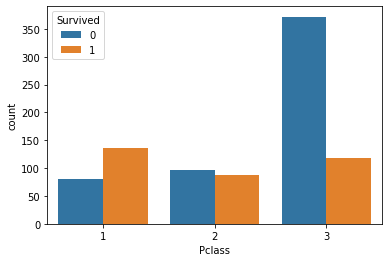

In [5]:
# The graph on the basis of Pclass shows that the ratio of the dead - surviving people is larger in 3rd class (Lower)
sns.countplot(data=df_train, x='Pclass', hue='Survived');

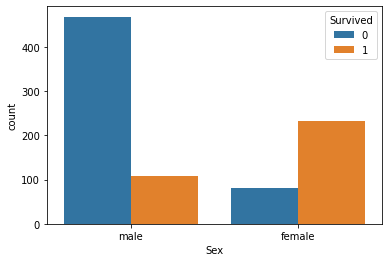

In [6]:
# Distribution of surviving people based on gender
sns.countplot(data=df_train, x='Sex', hue='Survived');

In [7]:
# The first assumptions that passengers of the 1st class have a chance for survival and women
df_train.pivot_table(values=["Survived"], index=["Pclass","Sex"], aggfunc=np.mean)

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

In [8]:
# We will analyze the feature - Name. It can be distinguished by groups of people according to the titles (Mr, Miss, Mrs)
# People - representative people probably have more chances for survival

# We will create a new feature based on titles from a feature of Name
# It can be seen what is the most - Mr, Miss, Mrs. The rest are rare titles
df_train['title'] = df_train['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
df_train['title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: title, dtype: int64

In [9]:
# Let's leave only a few popular titles and a couple of rare.
# The remaining titles are attributed to other titles
top_titles = list(df_train['title'].value_counts().head(6).keys())

# Created a new feature based on title (other - rare titles)
title_norm = defaultdict(lambda: 'other', dict(zip(top_titles, top_titles)))
df_train['title_norm'] = df_train['title'].map(title_norm)
df_train['title_norm'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
other      14
Dr          7
Rev         6
Name: title_norm, dtype: int64

In [10]:
# We change the categorical format for numerical (numerical marks for categories)
df_train['title_norm_cat'] = df_train['title_norm'].factorize()[0]
df_train['title_norm_cat'].value_counts()

0    517
2    182
1    125
3     40
4     14
6      7
5      6
Name: title_norm_cat, dtype: int64

In [12]:
# We will analyze the feature - Age. This feature has missed values
print(f"Number of passengers who do not indicate age: {df_train['Age'].isnull().sum()}")

# We will display information on passengers where age is not indicated. You can fill out the absent values based on the average or median ages according to the titles
df_train.loc[df_train['Age'].isnull()]

Number of passengers who do not indicate age: 177


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,title_norm,title_norm_cat
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr,Mr,0
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Mr,Mr,0
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Mrs,Mrs,1
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Mr,Mr,0
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss,Miss,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,Mr,Mr,0
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,Miss,Miss,2
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,Mr,Mr,0
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,Mr,Mr,0


In [13]:
# We will group age by titles and withdraw the average value of age in each group
dict_mean_age_by_title = df_train.groupby('title_norm').agg(np.mean)['Age'].to_dict()
dict_mean_age_by_title

{'Dr': 42.0,
 'Master': 4.574166666666667,
 'Miss': 21.773972602739725,
 'Mr': 32.368090452261306,
 'Mrs': 35.898148148148145,
 'Rev': 43.166666666666664,
 'other': 42.214285714285715}

In [14]:
# We group the same parameters, but take the median age, since the median is less susceptible to emissions
dict_median_age_by_title = df_train.groupby('title_norm').agg(np.median)['Age'].to_dict()
dict_median_age_by_title

{'Dr': 46.5,
 'Master': 3.5,
 'Miss': 21.0,
 'Mr': 30.0,
 'Mrs': 35.0,
 'Rev': 46.5,
 'other': 42.5}

In [15]:
# We will create new features in which we calculated the middle and median age
df_train['age_mean'] = df_train['title_norm'].map(dict_mean_age_by_title)
df_train['age_median'] = df_train['title_norm'].map(dict_median_age_by_title)

In [16]:
# Replace empty values with median values calculated earlier
df_train['Age'] = np.where(df_train['Age'].isnull(), df_train['age_median'].values, df_train['Age'].values)

In [17]:
# Let us analyze the features of Sibsp, Parch on possible relationships (children, parents, brothers, sisters)

# Assessment of the size of the family
df_train['family_size'] = df_train['SibSp'] + df_train['Parch'] + 1
df_train['family_single'] = df_train['family_size'] == 1
df_train['family_small'] = (df_train['family_size'] > 1) & (df_train['family_size'] < 5)
df_train['family_big'] = df_train['family_size'] > 4

# Is there already 18 years, then we think that an adult, if not, then we think that a child
df_train['child'] = df_train['age_mean'] < 18
df_train['adult'] = df_train['age_mean'] >= 18

# We are looking for mothers (this is definitely not a man, we assume that the age is more than 18 and the title is not miss)
def is_mother(row):
	if row['Sex'] == 'male': return False
	if row['title_norm_cat'] == 'miss': return False
	if row['age_mean'] < 18: return False
	return True

# 314 people are mothers
df_train['is_mother'] = df_train.apply(is_mother, axis=1)
print(df_train['is_mother'].value_counts())

False    577
True     314
Name: is_mother, dtype: int64


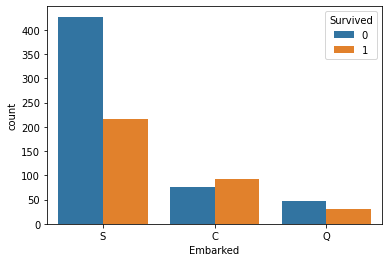

In [18]:
# Consider the feature of Embarked. It can be seen that most of the passengers sat on board in the city of Southampton. More passengers died from this city
# Embarked (C - Cherbourg, Q- Queenstown, S- Southampton)
sns.countplot(data=df_train, x='Embarked', hue='Survived');

In [19]:
# We change the categorical format for numerical (numerical marks for categories)
df_train['Embarked_cat'] = df_train['Embarked'].factorize()[0]
df_train['Embarked_cat'].value_counts()

 0    644
 1    168
 2     77
-1      2
Name: Embarked_cat, dtype: int64

Modeling

In [20]:
# List of models that will be tested on the dataset
list_models = [
	LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500),
	GaussianNB(),
	SVC(kernel='rbf'),
	KNeighborsClassifier(n_neighbors=3, p=1),
	DecisionTreeClassifier(max_depth=5),
	RandomForestClassifier(max_depth=5, n_estimators=60, random_state=0),
	lgbm.LGBMClassifier(max_depth=5, n_estimators = 60, random_state=0, learning_rate=0.3),
	xgb.XGBClassifier(max_depth=5, n_estimators = 60, random_state=0, learning_rate=0.3)
]

In [21]:
# Function for teaching model
def train_model(df, list_models):

	# Function for features selection
	def get_feats(df, black_list=set(['Survived', 'PassengerId'])):
		feats = df.select_dtypes(include=[np.number, np.bool_]).columns
		return [x for x in feats if x not in black_list]
	feats = get_feats(df)

	# Function for X, y
	def get_X_y(df, feats):
		X = df[feats].fillna(-1).values
		y = df['Survived'].values

		return X, y
	X, y = get_X_y(df, feats)

	# Standardization X for models that work better when scaling
	scaler = StandardScaler()
	X_std = scaler.fit_transform(X)

	# Information for creating a model report
	columns_describe = ['Classifier', 'Accuracy', 'Duration_sec']
	data_describe = []

	# Running the learning model
	for model in list_models:
		cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
		model_name = (str(model.__repr__).split("of")[-1].strip().split("(")[0].split(" ")[0].replace("classifier",""))

		# Run time to check the duration of an operation
		start_time = time.time()
		if model_name in ['LogisticRegression', 'GaussianNB', 'SVC', 'KNeighborsClassifier']:
			scores = cross_val_score(model, X_std, y, scoring='accuracy', cv=cv).mean()
		else:
			scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv).mean()
		end_time = time.time()

		data_describe.append([model_name, round(scores, 4), round((end_time - start_time), 4)])

	# Creating a report on models
	df_describe_score = pd.DataFrame(columns=columns_describe, data=data_describe)
	return df_describe_score

In [22]:
# The best model in the training sample with selected hyperparameters was SVC (method of support vectors)
df_report = train_model(df_train, list_models)
df_report = df_report.sort_values('Accuracy', ascending=False)
df_report

,Classifier,Accuracy,Duration_sec
2,SVC,0.8339,0.1783
5,RandomForestClassifier,0.8305,0.7670
0,LogisticRegression,0.8294,0.0892
6,LGBMClassifier,0.8148,0.1377
3,KNeighborsClassifier,0.8081,0.2818
7,XGBClassifier,0.8036,0.4154
4,DecisionTreeClassifier,0.7991,0.0174
1,GaussianNB,0.7823,0.0126


For test sample (results on kaggle)

In [23]:
# Predict the values of the target variable for test sample
# We load the test dataset and add the same signs as for training sampling
df_test = pd.read_csv('datasets/test_kaggle.csv')
df_test.shape

(418, 11)

In [24]:
# Convert signs for test sample
df_test['title'] = df_test['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())

top_titles = list(df_test['title'].value_counts().head(6).keys())
title_norm = defaultdict(lambda: 'other', dict(zip(top_titles, top_titles)))
df_test['title_norm'] = df_test['title'].map(title_norm)
df_test['title_norm_cat'] = df_test['title_norm'].factorize()[0]

dict_mean_age_by_title = df_test.groupby('title_norm').agg(np.mean)['Age'].to_dict()
dict_median_age_by_title = df_test.groupby('title_norm').agg(np.median)['Age'].to_dict()

df_test['age_mean'] = df_test['title_norm'].map(dict_mean_age_by_title)
df_test['age_median'] = df_test['title_norm'].map(dict_median_age_by_title)


df_test['family_size'] = df_test['SibSp'] + df_test['Parch'] + 1
df_test['family_single'] = df_test['family_size'] == 1
df_test['family_small'] = (df_test['family_size'] > 1) & (df_test['family_size'] < 5)
df_test['family_big'] = df_test['family_size'] > 4

df_test['child'] = df_test['age_mean'] < 18
df_test['adult'] = df_test['age_mean'] >= 18

def is_mother(row):
	if row['Sex'] == 'male': return False
	if row['title_norm_cat'] == 'miss': return False
	if row['age_mean'] < 18: return False
	return True

df_test['is_mother'] = df_test.apply(is_mother, axis=1)
df_test['Embarked_cat'] = df_test['Embarked'].factorize()[0]

In [25]:
# Function for features selection
def get_feats(df, black_list=set(['Survived', 'PassengerId'])):
	feats = df.select_dtypes(include=[np.number, np.bool_]).columns
	return [x for x in feats if x not in black_list]
feats = get_feats(df_train)

In [26]:
# Get X, y
X = df_train[feats].fillna(-1).values
y = df_train['Survived'].values
X_t = df_test[feats].fillna(-1).values		# TEST

# Standardization of features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_t_std = scaler.transform(X_t)		# TEST

In [27]:
# Cross-vidation, as in the training functions (check all the models and work out the results on Kaggle)
# The best model in the training sample with the selected hyperparameters was RandomForestClassifier - 0,77751
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

for model in list_models:
	model_name = (str(model.__repr__).split("of")[-1].strip().split("(")[0].split(" ")[0].replace("classifier",""))

	# Preservation of the results of predictions
	predicions = []
	for train_idx, test_idx in cv.split(X_std, y):
		X_train, X_test = X_std[train_idx], X_std[test_idx]
		y_train, y_test = y[train_idx], y[test_idx]
		model.fit(X_train, y_train)
		y_pred = model.predict(X_t_std)
		predicions.append(y_pred)
	
	df_test['Survived'] = np.median(predicions, axis=0)
	df_test['Survived'] = df_test['Survived'].astype('int')

	df_test[['PassengerId', 'Survived']].to_csv(f'results_test/Submit_test_{model_name}.csv', index=False)

# It can be concluded that the most optimal model with selected parameters is SVC and RandomForestClassifier